## Importing the required packages

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter
import cv2
import torch #importing pytorch so called torch
from torch import nn, optim # optim is for optimization.
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision import models
from torchvision import transforms
import torch.nn.functional as F
from torchvision.utils import make_grid


In this notebook, we define the following constants. It is a good practice to introduce your constants early in the notebook, for a higher visibility, using all capital letters for their names.

In [ ]:
MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)
HEIGHT = 32
WIDTH = 32
BATCH_SIZE = 32
NUM_EPOCHS = 100
BEST_MODEL_PATH = 'best_model.pth'

# Dataset
We use **_CIFAR10_** Dataset from *torchvision.datasets*. If you are using your own dataset, you can define your [custom Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) object.

 You can also use
[ImageFolder](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html) from **_torchvision.datasets_** to easily build a PyTorch Dataset in one line of code.

In [ ]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True)

valid_dataset = datasets.CIFAR10(root='./data', train=False, download=True)


100%|██████████| 170M/170M [00:03<00:00, 44.1MB/s]


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

train_dataset.transform = transform
valid_dataset.transform = transform

## Class Labels

In [ ]:
print(f'{"Class Label":<20} {"Class Name"}')
for label, name in enumerate(train_dataset.classes):
  print(f'{label:<20} {name}')

Class Label          Class Name
0                    airplane
1                    automobile
2                    bird
3                    cat
4                    deer
5                    dog
6                    frog
7                    horse
8                    ship
9                    truck


## **Always visualize your data**
Data visualization helps to identify issues in data. Remember, the model learns the patterns in your data. If there is a systematic error in your dataset, it can affect the performance of the developed model and its generalizability when applied to unseen data.

In [ ]:
def visualize_image_grid(image_label_pairs, class_names, rows, cols, mean=MEAN, std=STD):
  """
  Visualizes a grid of images with their labels.

  Args:
    image_label_pairs: A list of tuples, where each tuple is (image, label).
    rows: The number of rows where images are shown.
    cols: The number of columns where images are shown.
  """
  if len(image_label_pairs) != rows * cols:
    raise ValueError("The number of image-label pairs must exactly match rows * cols")
  fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
  for ax, (image, label) in zip(axes.flatten(), image_label_pairs):
    image = image.permute(1, 2, 0)
    image *= torch.Tensor(std)
    image += torch.Tensor(mean)
    ax.imshow(image)
    ax.set_title(f"class {label}: {names[label].title()}")
    ax.axis('off')
  plt.tight_layout()
  plt.show()



Visualizing a subset of images from the training dataset; please note that these images have undergone **`train_transform`**: transformation.

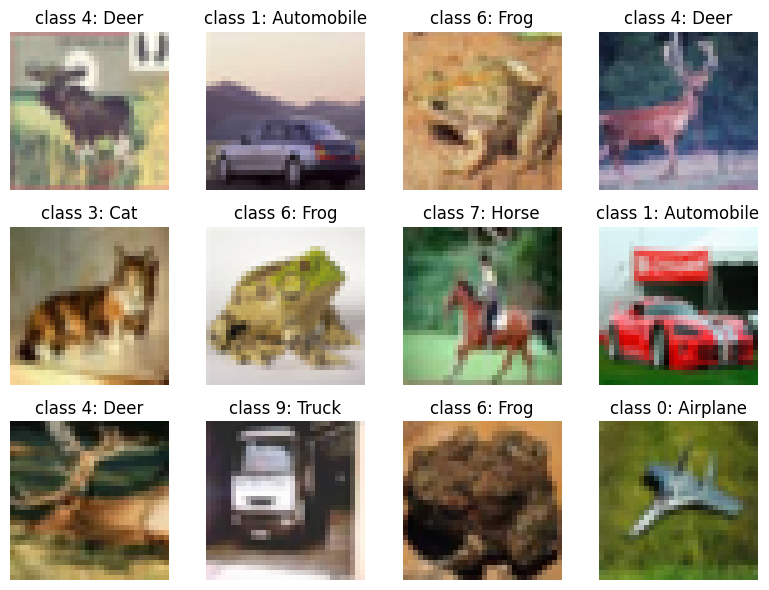

In [ ]:
rows = 3
columns = 4
data = train_dataset
names = train_dataset.classes
indices = np.random.randint(low=0, high=len(data), size=rows*columns)
train_examples = [data[i] for i in indices]
visualize_image_grid(train_examples, names, rows, columns)

Visualizing a subset of images from the validation dataset; please note that these images have undergone **`valid_test_transform`**: transformation.

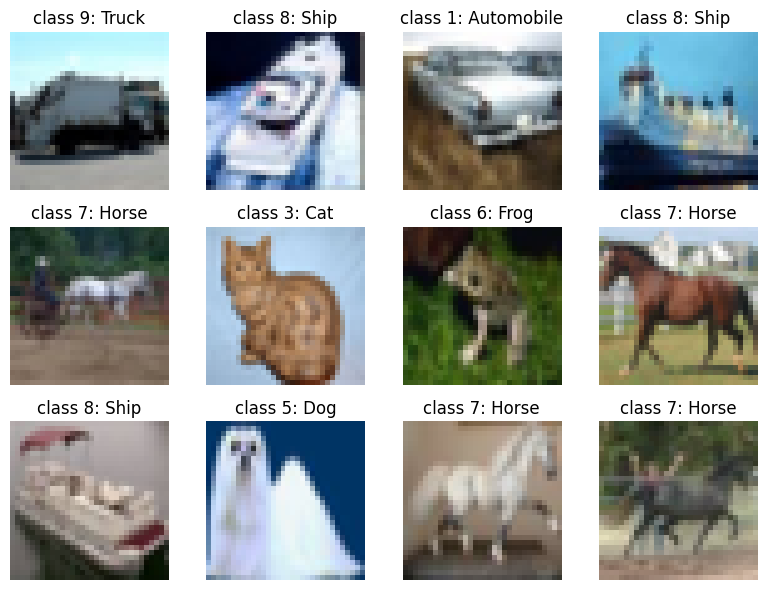

In [ ]:
rows = 3
columns = 4
data = valid_dataset
indices = np.random.randint(low=0, high=len(data), size=rows*columns)
train_examples = [data[i] for i in indices]
visualize_image_grid(train_examples, names, rows, columns)

In [ ]:
class MLP(nn.Module):
    def __init__(self, number_of_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(HEIGHT*WIDTH*3, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, number_of_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = MLP(10)
print(model)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)


## Define `DataLoader` objects
`DataLoader` is a powerful utility that offers seamless iteration over datasets. It abstracts the complexity of data loading, making it easier to work with large datasets that may not fit entirely in memory.

The `DataLoader` supports automatic batching of data. It also provides flexibility for customizing data loading order and loading data in parallel using multiprocessing.

In [ ]:
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, BATCH_SIZE, shuffle=False)

#Selecting the device for model training and evaluation
You can traing and test your model on **CPU** or **GPU**. The latter is much faster and if available should be the choice for model training.

The following line of code defines the device to be GPU if it is available and CPU otherwise:

```python
device = torch.device("cuda" if torch.cuda.is_available() else "cpu");
```

**Note:** Google Colab offers a T4 GPU for free. Make sure to activate it under *Edit/Notebook settings* from the colab menu. You can also purchase the V100 and A100 resources, which are computationally stronger and faster.
**Please note that both are subject to monthly and usage caps.**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu");
model = model.to(device)

## Loss function

We set up the loss function for model training to be **Cross Entropy Loss**, which is commonly used for classification tasks. It measures the performance of a classification model whose output is a probability value between 0 and 1.

In [ ]:
criterion = nn.CrossEntropyLoss()


## Optimization algorithm
We use the **Stochastic Gradient Descent (SGD)** as the optimization algorithm for the model. The `model.parameters()` function provides the model’s parameters to the optimizer. The learning rate (`lr`) is set to 0.01, and the `momentum` is set to 0.9.

The learning rate controls how much to change the model in response to the estimated error each time the model weights are updated.
The momentum can help the model to converge faster and avoid local minima.

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
# Training Loop
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    correct_predictions = 0
    total_predictions = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # Get inputs and labels
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        total_predictions += labels.size(0)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        # Calculate accuracy (correct predictions)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / total_predictions
    epoch_accuracy = correct_predictions / total_predictions
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {100* epoch_accuracy:.2f}%')
print('Finished Training')

# Save the trained model
torch.save(model.state_dict(), BEST_MODEL_PATH)

# Testing the Model
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for data in valid_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.detach(), 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on 10,000 test images: {100 * correct / total:.2f}%')

Epoch [1/20], Loss: 1.6937, Accuracy: 39.76%
Epoch [2/20], Loss: 1.5372, Accuracy: 45.88%
Epoch [3/20], Loss: 1.4622, Accuracy: 48.27%
Epoch [4/20], Loss: 1.4092, Accuracy: 50.29%
Epoch [5/20], Loss: 1.3774, Accuracy: 51.34%
Epoch [6/20], Loss: 1.3321, Accuracy: 53.16%
Epoch [7/20], Loss: 1.2908, Accuracy: 54.52%
Epoch [8/20], Loss: 1.2641, Accuracy: 55.49%
Epoch [9/20], Loss: 1.2361, Accuracy: 56.62%
Epoch [10/20], Loss: 1.2115, Accuracy: 57.52%
Epoch [11/20], Loss: 1.1850, Accuracy: 57.93%
Epoch [12/20], Loss: 1.1520, Accuracy: 59.35%
Epoch [13/20], Loss: 1.1261, Accuracy: 60.28%
Epoch [14/20], Loss: 1.1146, Accuracy: 61.14%
Epoch [15/20], Loss: 1.0898, Accuracy: 61.78%
Epoch [16/20], Loss: 1.0780, Accuracy: 62.41%
Epoch [17/20], Loss: 1.0647, Accuracy: 62.86%
Epoch [18/20], Loss: 1.0407, Accuracy: 64.06%
Epoch [19/20], Loss: 1.0390, Accuracy: 64.09%
Epoch [20/20], Loss: 1.0372, Accuracy: 64.14%
Finished Training
Accuracy on 10,000 test images: 47.97%


In [ ]:
def evaluate_model(model, valid_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    iteration = 0
    # No need to track gradients during evaluation
    with torch.no_grad():
        for data in valid_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Accumulate the loss
            running_loss += loss.item() * inputs.size(0)

            # Get predicted labels
            _, predicted = torch.max(outputs.detach(), 1)

            # Count total and correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate the average loss and accuracy
    avg_loss = running_loss / total
    accuracy = 100 * correct / total

    print(f'Validation Loss: {avg_loss:.4f}, Validation Accuracy: {accuracy:.2f}%')
    return avg_loss, accuracy


In [ ]:
evaluate_model(model, valid_loader, criterion, device)

Validation Loss: 1.9471, Validation Accuracy: 47.97%


(1.9470527320861817, 47.97)